In [ ]:
!mkdir '/content/data'
!unzip "/content/drive/My Drive/COMP9517 20T2 Group Project Image Sequences.zip" -d '/content/data'

Archive:  /content/drive/My Drive/COMP9517 20T2 Group Project Image Sequences.zip
   creating: /content/data/DIC-C2DH-HeLa/
   creating: /content/data/DIC-C2DH-HeLa/Sequence 1/
   creating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t002mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t005mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t021mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t031mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t033mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t034mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t039mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t054mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t067mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1/t000.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Seq

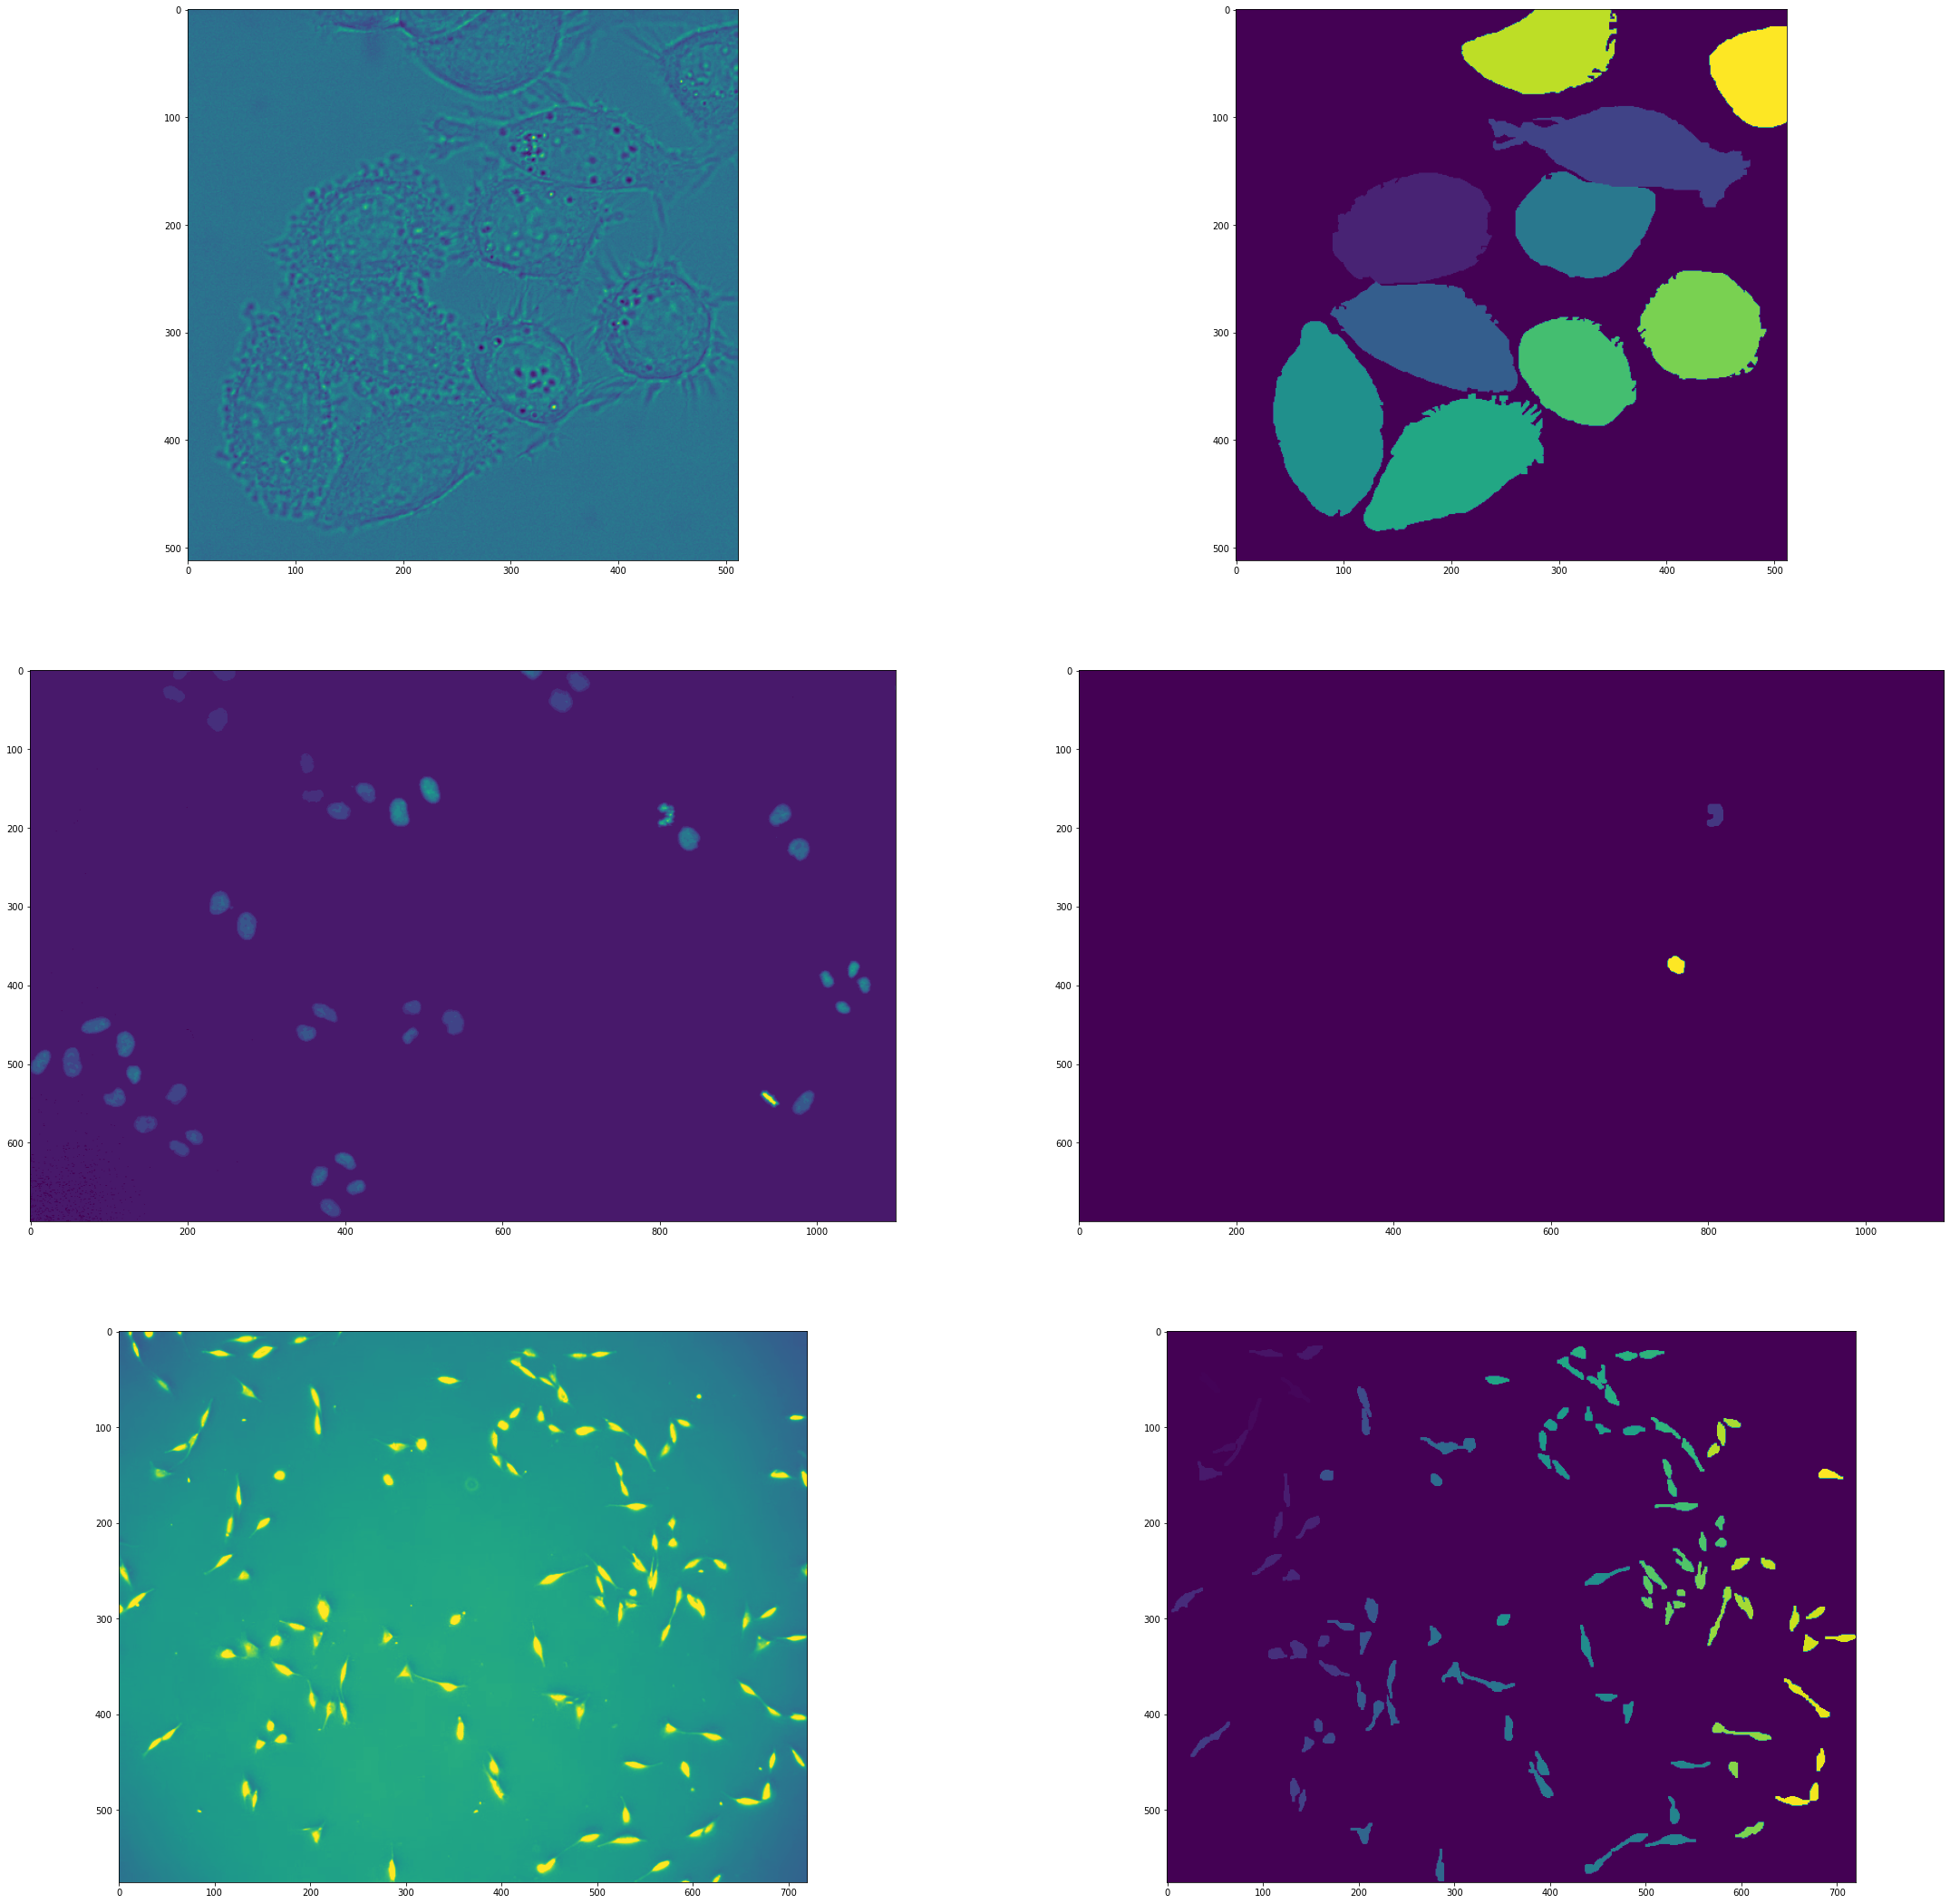

In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os.path import join

dic_path = '/content/data/DIC-C2DH-HeLa/'
fluo_path = '/content/data/Fluo-N2DL-HeLa/'
phc_path = '/content/data/PhC-C2DL-PSC/'

# test img display
f = plt.figure(figsize=(38, 38))
# dic
dic_test = cv2.imread(join(dic_path, 'Sequence 1/t002.tif'),0)
dic_testmask = cv2.imread(join(dic_path, 'Sequence 1 Masks/t002mask.tif'), -1)
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax1.imshow(dic_test)
ax2.imshow(dic_testmask)
# fluo
fluo_test = cv2.imread(join(fluo_path, 'Sequence 1/t012.tif'),0)
fluo_testmask = cv2.imread(join(fluo_path, 'Sequence 1 Masks/t012mask.tif'), -1)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax3.imshow(fluo_test)
ax4.imshow(fluo_testmask)
# phc
phc_test = cv2.imread(join(phc_path, 'Sequence 1/t098.tif'),0)
phc_testmask = cv2.imread(join(phc_path, 'Sequence 1 Masks/t098mask.tif'), -1)
ax5 = f.add_subplot(3,2,5)
ax6 = f.add_subplot(3,2,6)
ax5.imshow(phc_test)
ax6.imshow(phc_testmask)

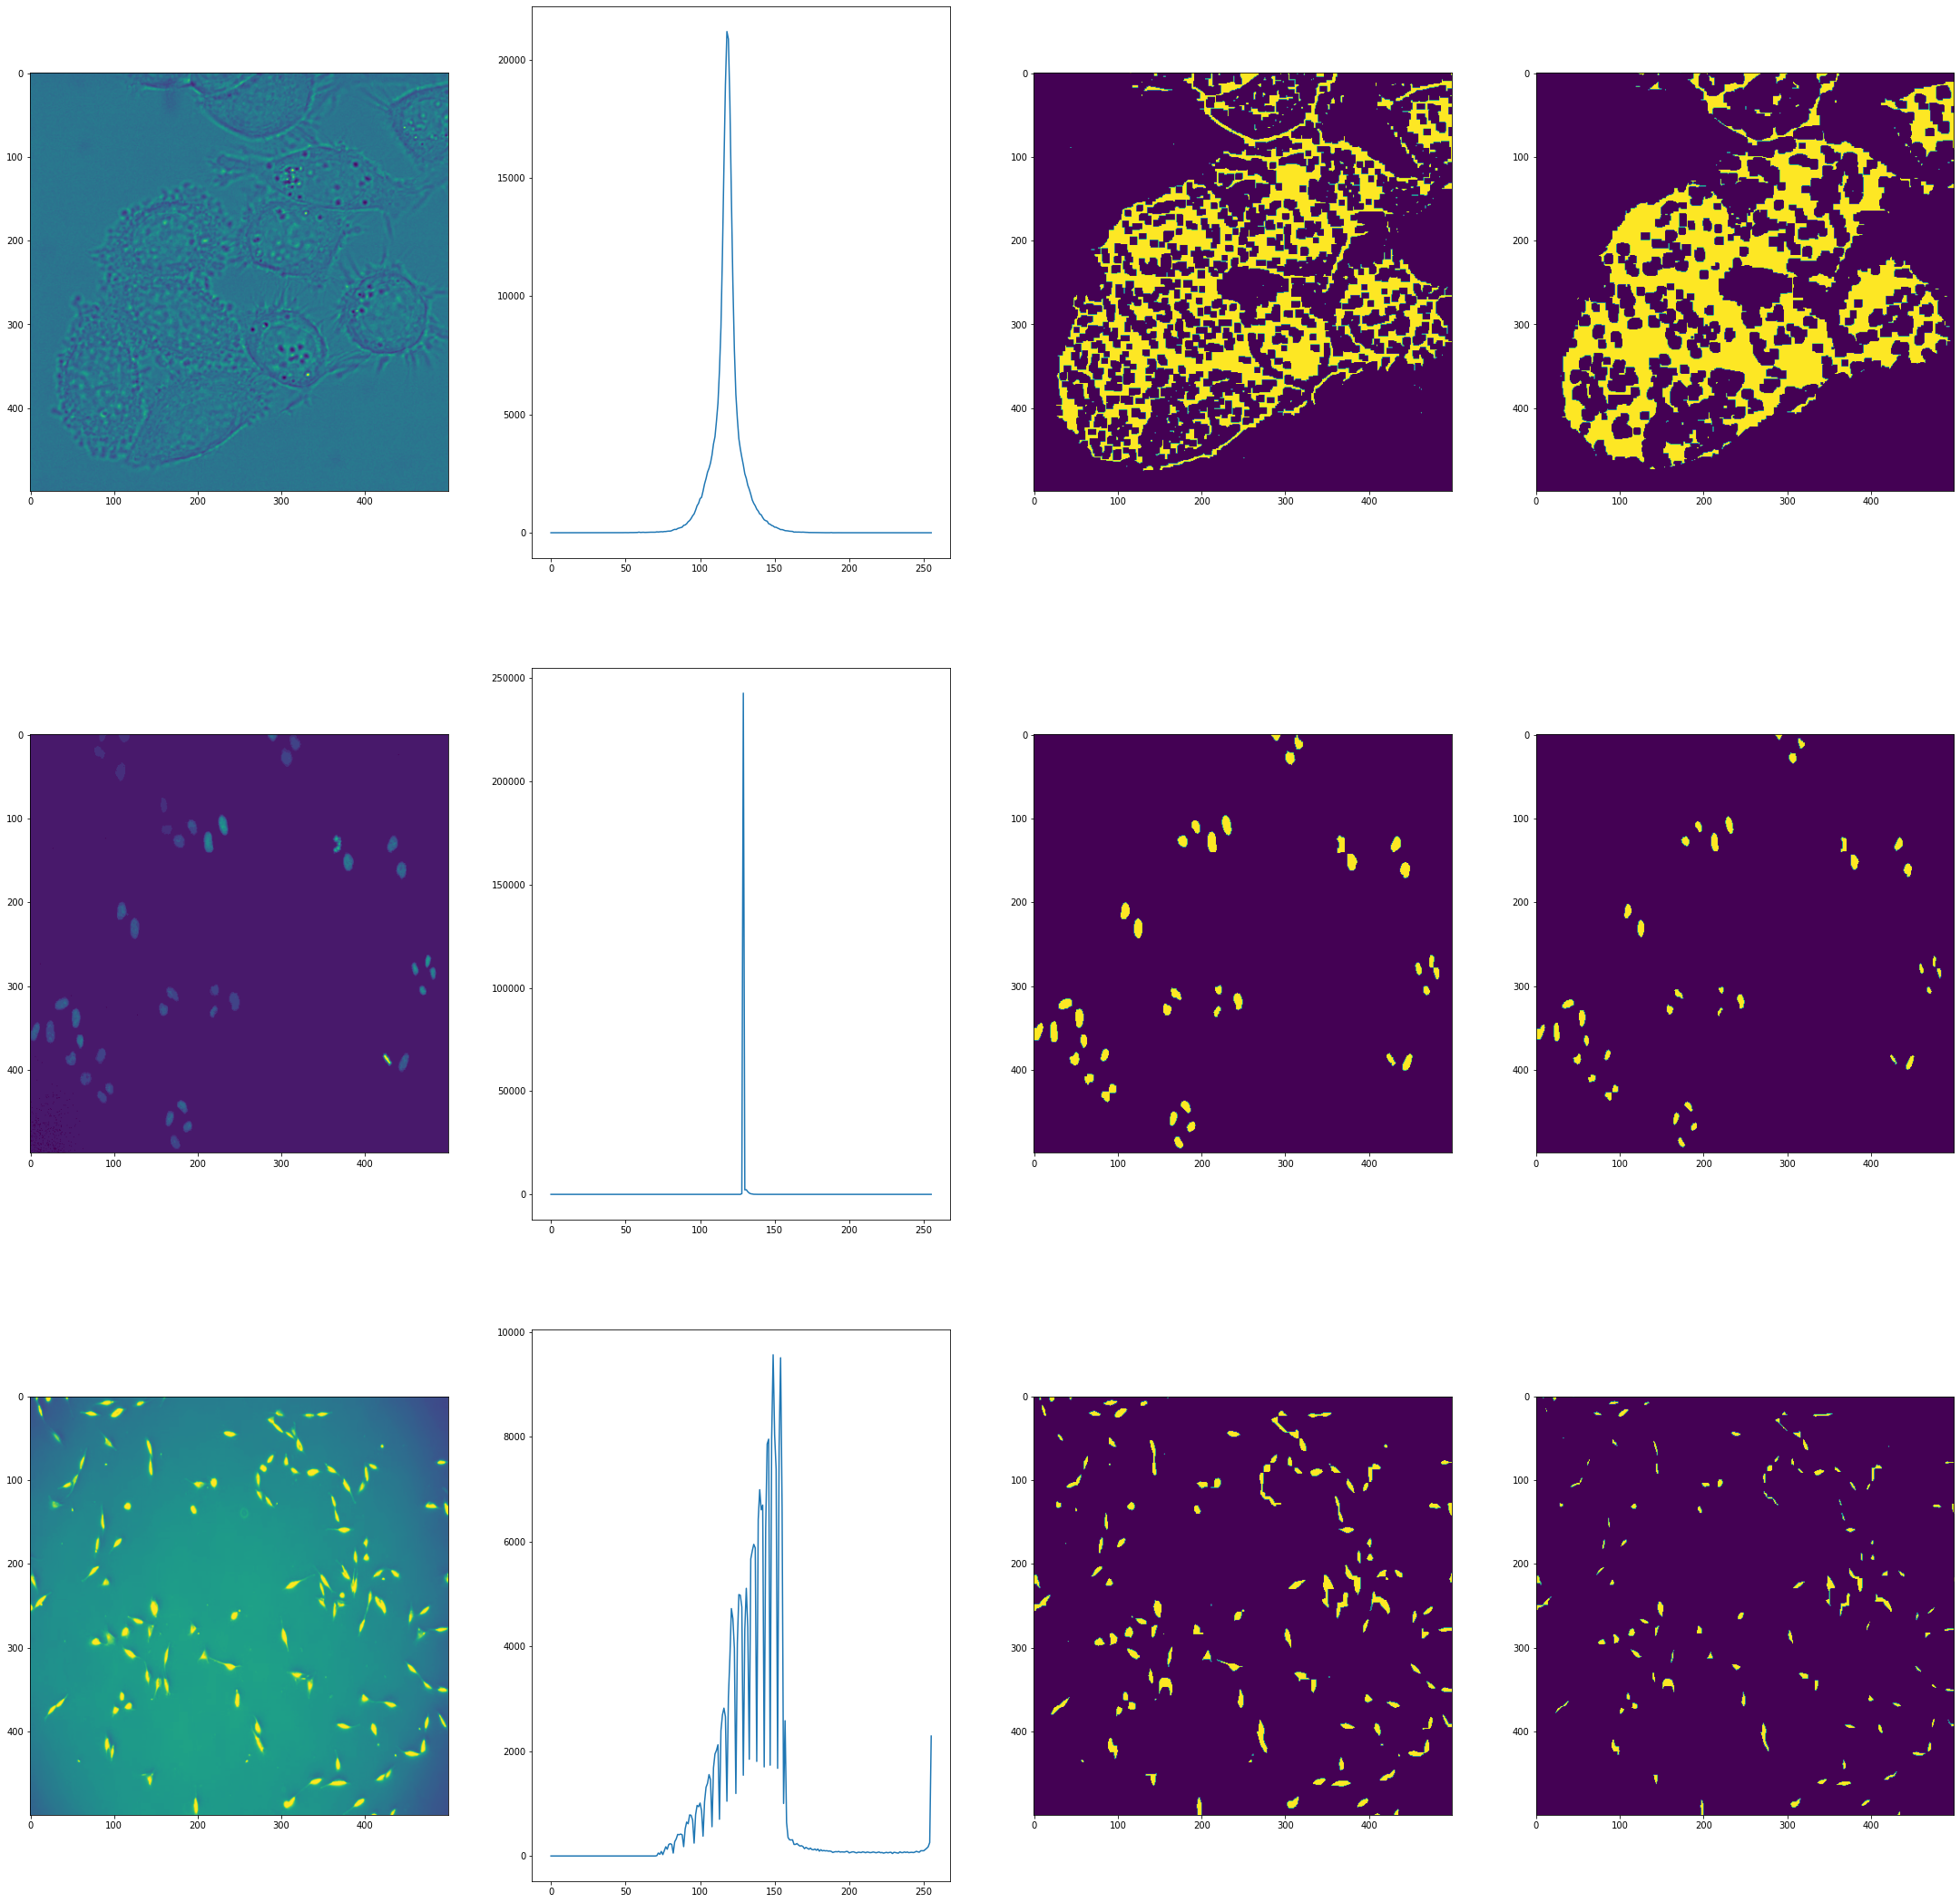

In [67]:
def thres_preprocessing(img, f=None, i=None):
    resized_img = cv2.resize(img, (500, 500))
    # do background elimination and then proceed Otsu
    st = cv2.morphologyEx(resized_img, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8)) 
    st2 = cv2.morphologyEx(resized_img, cv2.MORPH_OPEN, np.ones((7,7),np.uint8)) 
    st2 = st - st2

    # Otsu's thresholding
    ret,th = cv2.threshold(st,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
    ret2,th2 = cv2.threshold(st2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
    th3 = cv2.bitwise_or(th, th2)

    # Further preprocessing to get a more general segmentation
    blur = cv2.blur(th3, (7,7))
    ret4,th4 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
    th5 = cv2.bitwise_or(cv2.morphologyEx(th4, cv2.MORPH_HITMISS, np.ones((5,5),np.uint8)), th)
    th5 = cv2.morphologyEx(th5, cv2.MORPH_HITMISS,np.ones((3,3),np.uint8)) 
    # th5 = cv2.blur(th5, (3,3))
    # ret5,th5 = cv2.threshold(th5,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 

    """
    Currently turned-off configurations
    """
    # im_floodfill = th5.copy()
    # h, w = th5.shape[:2]
    # mask = np.zeros((h+2, w+2), np.uint8)
    # cv2.floodFill(im_floodfill, mask, (0,0), 255)
    # im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    # im_out = th5 | im_floodfill_inv

    # th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8)) 

    """
    Debug-use img showing, need to include a figure of f
    """
    if f != None and i != None:  
        orig_hist = cv2.calcHist([resized_img],[0],None,[256],[0,256]) 
        new_hist = cv2.calcHist([th],[0],None, [256],[0,256])

        ax = f.add_subplot(3,4,i)
        ax.imshow(resized_img)
        ax0 = f.add_subplot(3,4,i+1)
        ax0.plot(orig_hist)
        ax1 = f.add_subplot(3,4,i+2)
        ax1.imshow(th)
        ax2 = f.add_subplot(3,4,i+3)
        ax2.imshow(th5)

    return resized_img, th, th5 # return resized img, threshold type1, threshold type2

# Test uses
f2 = plt.figure(figsize=(38, 38))
dic_resized, dic_th, dic_th2 = preprocessing(dic_test, f2, 1)
fluo_resized, fluo_th, fluo_th2 = preprocessing(fluo_test, f2, 5)
phc_resized, phc_th, phc_th2 = preprocessing(phc_test, f2, 9)

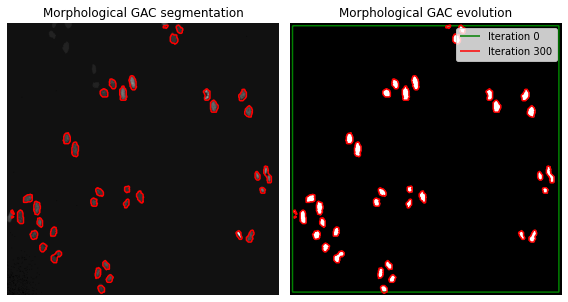

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,circle_level_set,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def initial_circle_ls(shape, level_size):
    circles_ls = np.zeros(shape)
    x, y = shape
    for i in range(level_size):
        for j in range(level_size):
            cls = circle_level_set(shape, 
                                   (int(x/(level_size*2) + i* (x/level_size)), 
                                    int(y/(level_size*2) + j* (y/level_size))), 
                                   int(x/(level_size*2)))
            circles_ls += cls
    return circles_ls
    
def level_set_segmentation(img, iteration = 300,
                                level_set='default', 
                                level_size=4):
    # get gradients
    gimg = inverse_gaussian_gradient(img, alpha=1.0, sigma=1.0)

    init_ls = None
    # decide level set type
    if level_set == 'default':
        init_ls = np.zeros(img.shape, dtype=np.int8)
        init_ls[5:-5, 5:-5] = 1
    elif level_set == 'checkerboard':
        init_ls = checkerboard_level_set(img.shape, level_size)
        reverse_ls = checkerboard_level_set
    elif level_set == 'circles':
        init_ls = initial_circle_ls(img.shape, level_size)
    
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_geodesic_active_contour(gimg, iteration, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.8,
                                               iter_callback=callback)
    
    return ls, evolution

# test 
img2 = cv2.resize(fluo_test, (500, 500))
img = cv2.resize(fluo_th, (500, 500))
ls, evolution = level_set_segmentation(img, 250)

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()
ax[0].imshow(img2, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 300")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

In [54]:
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

def add_boundingbox(path, img, ls): # overwrite the file at the path with the bounding-boxed img
    label_img = label(ls)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

    for region in regionprops(label_img):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(path)

In [ ]:
import shutil
import os.path as path
import os

from progress_bar import ProgressBar

def add_boundingbox_for_all(src, dest, iteration = 250, # operational arguments for level-set parameter tuning
                                     initial_ls_type='default', 
                                     level_size=4):
    if not path.exists(dest):
        destination = shutil.copytree(src, dest, copy_function = shutil.copy)

    # count how many images to process
    count = 0
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            count += 1
    
    # do the boundings in the dest repo
    progress = ProgressBar()
    i = 0
    progress.update_progress(0)
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            # load the img
            img = cv2.imread(path.join(dirpath, file),0)
            # do img preprocessing
            resized_img, thres, thres2 = thres_preprocessing(img)
            # get the segmentation
            # The first output is the final segmentation result
            # The second output contains all history segmentation results during 
            # the level-set converging procedure
            ls, _ = level_set_segmentation(thres, iteration = iteration,
                                                level_set=initial_ls_type, 
                                                level_size=level_size)
            # get the bounding-boxes
            add_boundingbox(path.join(dirpath, file), resized_img, ls)

            # progress bar
            i += 1
            progress.update_progress(i/count)

# test
add_boundingbox_for_all(fluo_path, '/content/fluo/')

Progress: [#########-----------] 46.6%


In [80]:
! rm -r /content/dic/